# Run-or-walk

This notebook describes experiments on [Kaggle run-or-walk](https://www.kaggle.com/vmalyi/run-or-walk) dataset.

Model used: fully connected neural network (3-30-2) with ReLU activation function.

In [1]:
import numpy as np
import pandas as pd

In [2]:
DATASET = 'dataset.csv'

In [3]:
dataset = pd.read_csv(DATASET)
len(dataset)

88588

In [4]:
dataset.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88588 entries, 0 to 88587
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            88588 non-null  object 
 1   time            88588 non-null  object 
 2   username        88588 non-null  object 
 3   wrist           88588 non-null  int64  
 4   activity        88588 non-null  int64  
 5   acceleration_x  88588 non-null  float64
 6   acceleration_y  88588 non-null  float64
 7   acceleration_z  88588 non-null  float64
 8   gyro_x          88588 non-null  float64
 9   gyro_y          88588 non-null  float64
 10  gyro_z          88588 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 7.4+ MB


In [6]:
dataset.describe()

,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
count,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000
mean,0.522170,0.500801,-0.074811,-0.562585,-0.313956,0.004160,0.037203,0.022327
std,0.499511,0.500002,1.009299,0.658458,0.486815,1.253423,1.198725,1.914423
min,0.000000,0.000000,-5.350500,-3.299000,-3.753800,-4.430600,-7.464700,-9.480000
25%,0.000000,0.000000,-0.381800,-1.033500,-0.376000,-0.920700,-0.644825,-1.345125
50%,1.000000,1.000000,-0.059500,-0.759100,-0.221000,0.018700,0.039300,0.006900
75%,1.000000,1.000000,0.355500,-0.241775,-0.085900,0.888800,0.733700,1.398200
max,1.000000,1.000000,5.603300,2.668000,1.640300,4.874200,8.498000,11.266200


In [7]:
dataset['activity'].value_counts()

1    44365
0    44223
Name: activity, dtype: int64

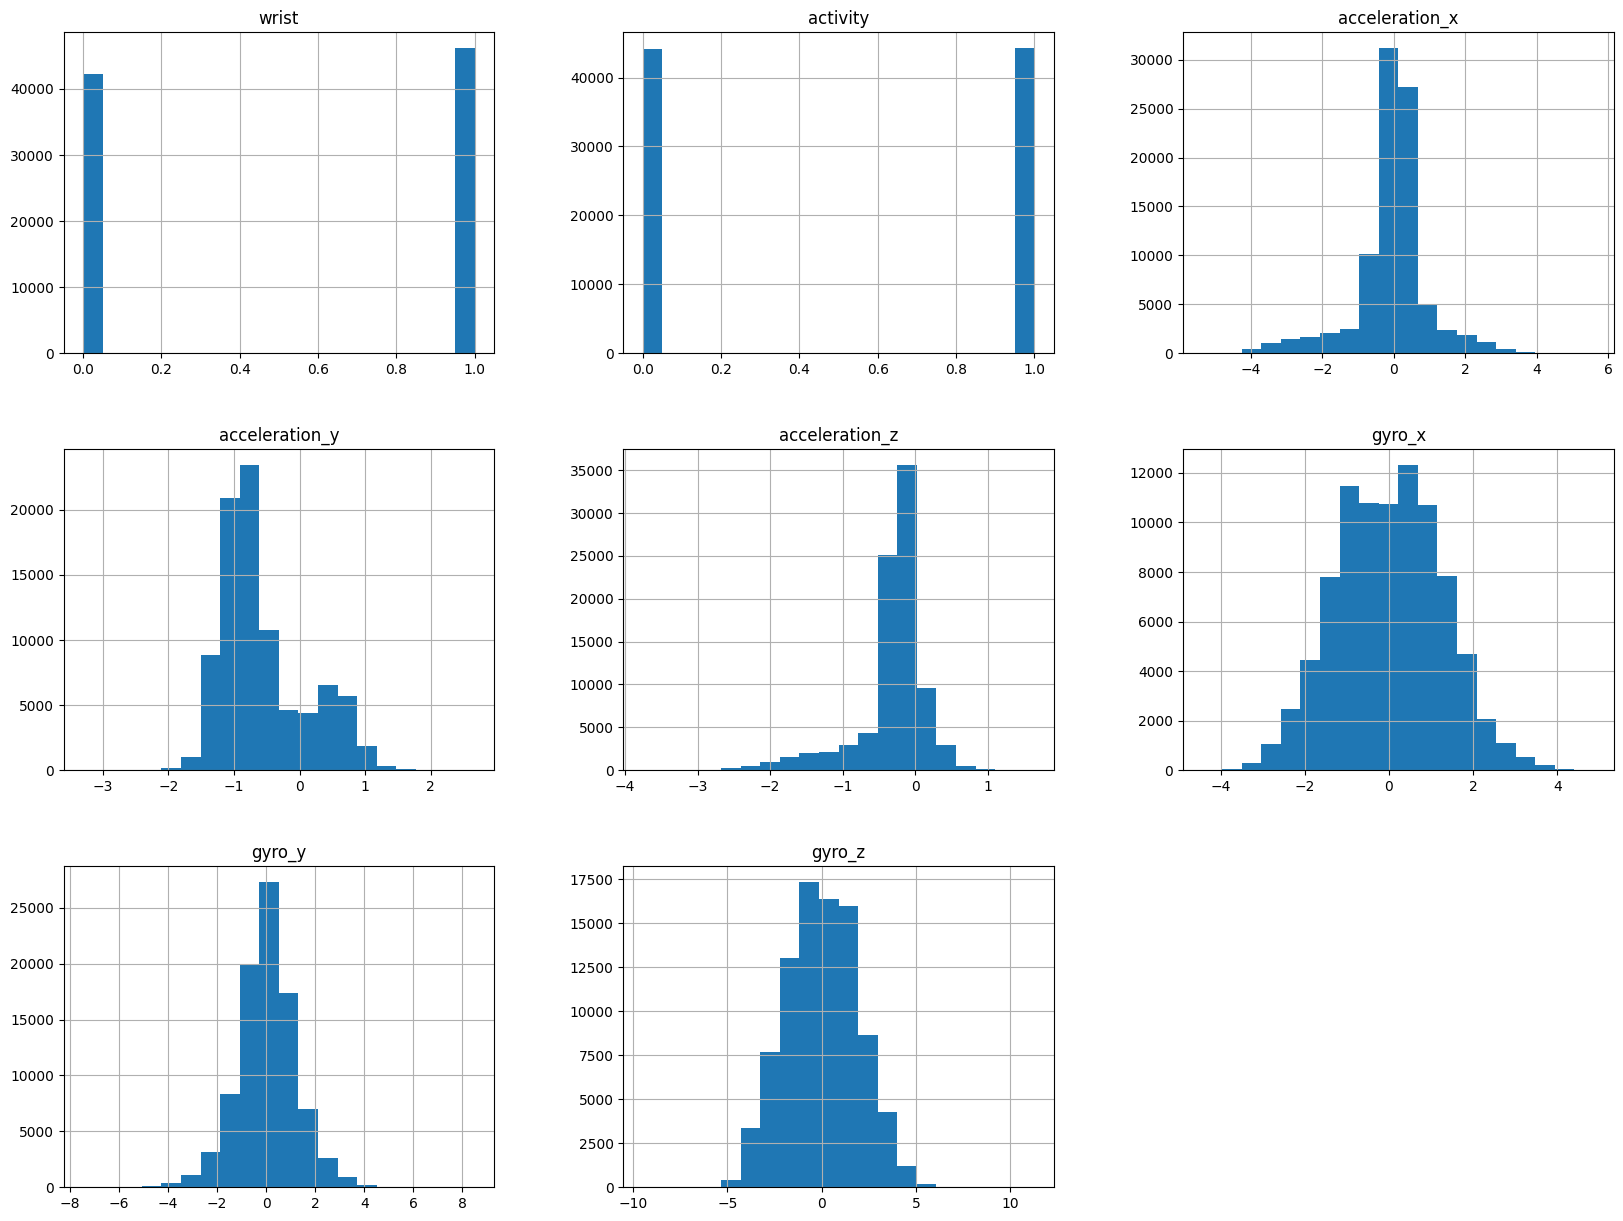

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

dataset.hist(bins=20, figsize=(20,15))
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

In [10]:
X_train = train_set.drop(['activity', 'date', 'time', 'username', 'wrist'], axis=1)
y_train = train_set['activity'].copy()

X_test = test_set.drop(['activity', 'date', 'time', 'username', 'wrist'], axis=1)
y_test = test_set['activity'].copy()

len(X_train), len(X_test)

(70870, 17718)

In [11]:
X_train

,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
37105,-0.4291,-0.9448,-0.1587,0.5133,0.0302,-1.3252
54378,-3.6026,0.5334,0.6149,4.0632,2.6766,2.4004
86477,-0.4766,0.0577,-0.9178,-0.1882,-0.0985,-0.0887
84774,-0.0273,-0.4416,0.1075,1.8468,-0.3828,0.8891
19425,-0.6380,-0.4388,-0.0112,0.4485,-0.6785,-0.1659
...,...,...,...,...,...,...
6265,-0.1714,-1.0067,-0.2231,-1.4891,0.1767,1.7018
54886,0.4980,-1.0698,-0.1829,1.0147,1.0042,3.2428
76820,0.3459,-0.8581,-0.0603,-0.6830,-0.0735,-1.3448
860,-0.4821,-0.5633,0.0581,0.4138,0.5662,0.6665


In [12]:
y_train

37105    0
54378    1
86477    1
84774    1
19425    1
        ..
6265     0
54886    0
76820    0
860      1
15795    1
Name: activity, Length: 70870, dtype: int64

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ImuDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return torch.Tensor(self.X.iloc[index].astype(float)), self.y.iloc[index]
    
    def __len__(self):
        return len(self.X)

In [14]:
input_size = 6
hidden_size = 30
num_classes = 2
num_epochs = 5
batch_size = 64
learning_rate = 0.001
device = torch.device('cpu')

In [15]:
train_dataset = ImuDataset(X_train, y_train)
test_dataset = ImuDataset(X_test, y_test)

In [16]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [17]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCN, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out) 
        return out

In [18]:
model = FCN(input_size, hidden_size, num_classes).to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
def test_accuracy():
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for data, labels in test_loader:
            labels = labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy on test set: {acc:.4f}%')

In [21]:
print('Before training')
test_accuracy()

Before training
Accuracy on test set: 59.8939%


In [22]:
n_total_steps = len(train_loader)
n_total_steps

1108

In [23]:
for epoch in range(num_epochs):
    for i, (data, label) in enumerate(train_loader):
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 300 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}: loss = {loss.item():.4f}')

Epoch 1/5, step 1/1108: loss = 0.6808
Epoch 1/5, step 301/1108: loss = 0.3115
Epoch 1/5, step 601/1108: loss = 0.1798
Epoch 1/5, step 901/1108: loss = 0.1085
Epoch 2/5, step 1/1108: loss = 0.1263
Epoch 2/5, step 301/1108: loss = 0.0769
Epoch 2/5, step 601/1108: loss = 0.0299
Epoch 2/5, step 901/1108: loss = 0.0905
Epoch 3/5, step 1/1108: loss = 0.0451
Epoch 3/5, step 301/1108: loss = 0.0298
Epoch 3/5, step 601/1108: loss = 0.1247
Epoch 3/5, step 901/1108: loss = 0.0846
Epoch 4/5, step 1/1108: loss = 0.0187
Epoch 4/5, step 301/1108: loss = 0.0584
Epoch 4/5, step 601/1108: loss = 0.1405
Epoch 4/5, step 901/1108: loss = 0.0463
Epoch 5/5, step 1/1108: loss = 0.0567
Epoch 5/5, step 301/1108: loss = 0.1109
Epoch 5/5, step 601/1108: loss = 0.0637
Epoch 5/5, step 901/1108: loss = 0.0191


In [24]:
print('After training')
test_accuracy()

After training
Accuracy on test set: 98.4366%


In [26]:
torch.save(model, 'fcnn.pth')